# Unsupervised Clustering on Eventfulness Vector Data

This notebook implements unsupervised clustering algorithms to analyze and cluster eventfulness vector data from the Excel file.


# Opening and Analyzing Excel Data

This notebook opens and analyzes the data from `peak_frames_data2.xlsx`


In [2]:
# Check and install necessary packages
import sys
import subprocess

required_packages = {
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'numpy': 'numpy',
    'openpyxl': 'openpyxl',  # Required for Excel file handling
    'xlrd': 'xlrd',
    'seaborn': 'seaborn',
    'sklearn': 'sklearn',
    'ast': 'ast'
}

def install_if_missing(package_name, import_name):
    try:
        __import__(import_name)
        print(f"✓ {package_name} is already installed")
    except ImportError:
        print(f"Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"✓ {package_name} has been installed")

for import_name, package_name in required_packages.items():
    install_if_missing(package_name, import_name)



✓ pandas is already installed
✓ matplotlib is already installed
✓ numpy is already installed
✓ openpyxl is already installed
✓ xlrd is already installed
✓ seaborn is already installed
✓ sklearn is already installed
✓ ast is already installed


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import ast
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')


In [4]:
# File path
excel_file = '/home/is1893/Mirror2/peak_frames_data2.xlsx'

# Add error handling for file loading
try:
    # Check if file exists
    if not os.path.exists(excel_file):
        raise FileNotFoundError(f"Excel file not found at: {excel_file}")
    
    # Load the Excel file with engine specification
    if excel_file.endswith('.xlsx'):
        df = pd.read_excel(excel_file, engine='openpyxl')
    elif excel_file.endswith('.xls'):
        df = pd.read_excel(excel_file, engine='xlrd')
    else:
        df = pd.read_excel(excel_file)
    
    # Display the first few rows of the dataframe
    print("Excel file loaded successfully!")
    df.head()
    
except Exception as e:
    print(f"Error loading Excel file: {str(e)}")
    print("Please check if the file exists and if you have the necessary permissions.")


Excel file loaded successfully!


In [5]:
# Get basic information about the dataframe
try:
    print("DataFrame Info:")
    df.info()
    
    print("\nDataFrame Description:")
    df.describe()
except NameError:
    print("DataFrame 'df' is not defined. Please make sure the Excel file was loaded successfully.")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ans                  11 non-null     int64  
 1   index                11 non-null     int64  
 2   peak_index           11 non-null     int64  
 3   frame_number         11 non-null     int64  
 4   time                 11 non-null     float64
 5   peak_value           11 non-null     float64
 6   vector_magnitude     11 non-null     float64
 7   image_filename       11 non-null     object 
 8   eventfulness_vector  11 non-null     object 
dtypes: float64(3), int64(4), object(2)
memory usage: 920.0+ bytes

DataFrame Description:


In [6]:
# Check for missing values
try:
    print("Missing Values:")
    df.isnull().sum()
    
    # Additional check for blank values (empty strings)
    print("\nBlank Values (empty strings):")
    blank_values = {}
    for column in df.columns:
        if df[column].dtype == object:  # Only check string/object columns
            blank_values[column] = (df[column] == '').sum()
    print(pd.Series(blank_values))
except NameError:
    print("DataFrame 'df' is not defined. Please make sure the Excel file was loaded successfully.")


Missing Values:

Blank Values (empty strings):
image_filename         0
eventfulness_vector    0
dtype: int64


## Data Exploration

Below you can add more cells for specific analysis of the data


In [ ]:
# Goal: create an unsupervised clustering model to cluster the eventfulness vectors, the expected output should be that even and odd indices are in different clusters

df['eventfulness_vector_parsed'] = df['eventfulness_vector'].apply(lambda x: np.array(ast.literal_eval(x)))

# Create a new DataFrame with the vectors expanded into separate columns
# This is necessary because sklearn expects a 2D array with each feature in a separate column
X = pd.DataFrame(df['eventfulness_vector_parsed'].tolist())
X = X.iloc[1:].reset_index(drop=True)

leftIndex = 4
rightIndex = leftIndex + 2
X = X.iloc[:, leftIndex:rightIndex] 
print(f"Using features: {list(X.columns)}")


# Preprocess the data
if X is not None:
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Data scaled successfully")
    
    # Apply PCA for visualization (if vector dimension > 2)
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        print(f"Applied PCA for visualization. Explained variance ratio: {pca.explained_variance_ratio_}")
        
        # Plot the PCA projection with different colors for odd and even indices
        plt.figure(figsize=(10, 8))
        
        # Create a boolean mask for even and odd indices
        even_mask = np.arange(len(X_pca)) % 2 == 0
        odd_mask = ~even_mask
        
        # Plot even indices in blue
        plt.scatter(X_pca[even_mask, 0], X_pca[even_mask, 1], alpha=0.7, color='blue', label='Even indices')
        # Plot odd indices in red
        plt.scatter(X_pca[odd_mask, 0], X_pca[odd_mask, 1], alpha=0.7, color='red', label='Odd indices')
        
        plt.title('PCA Projection of Eventfulness Vectors')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()
    else:
        X_pca = X_scaled
        print("No dimensionality reduction needed for visualization")


Silhouette Score: 0.3157
Clustering accuracy compared to even/odd indices: 0.8000


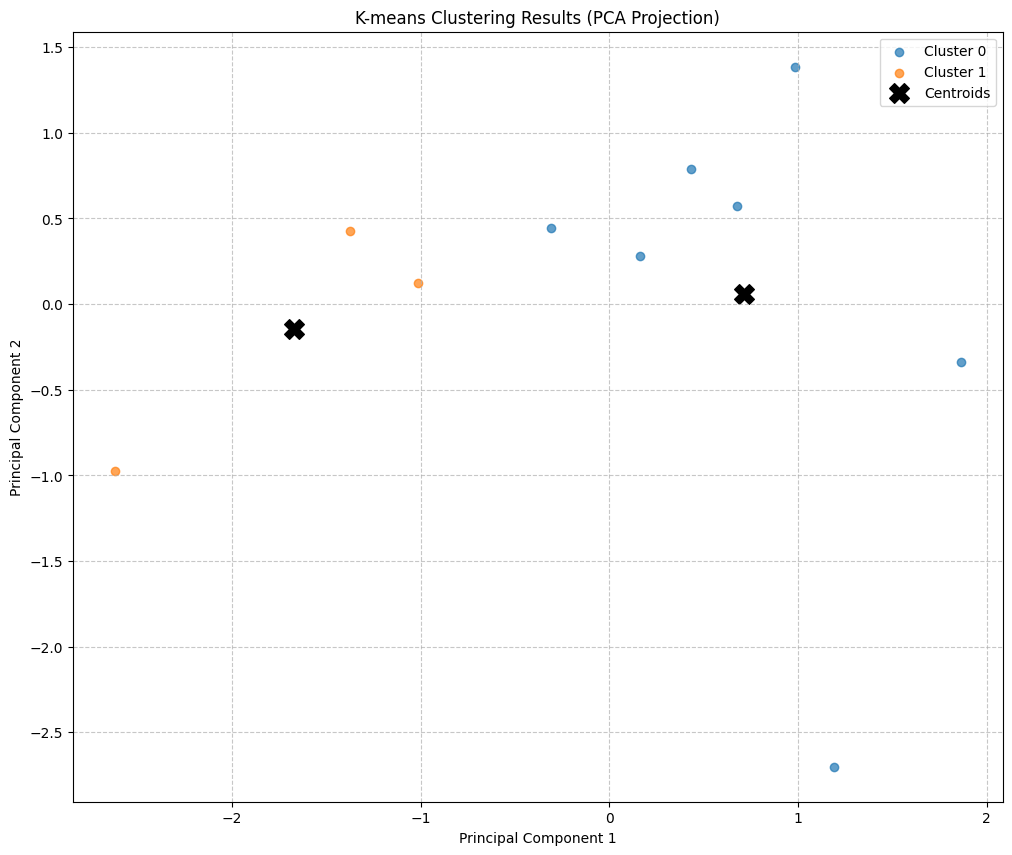

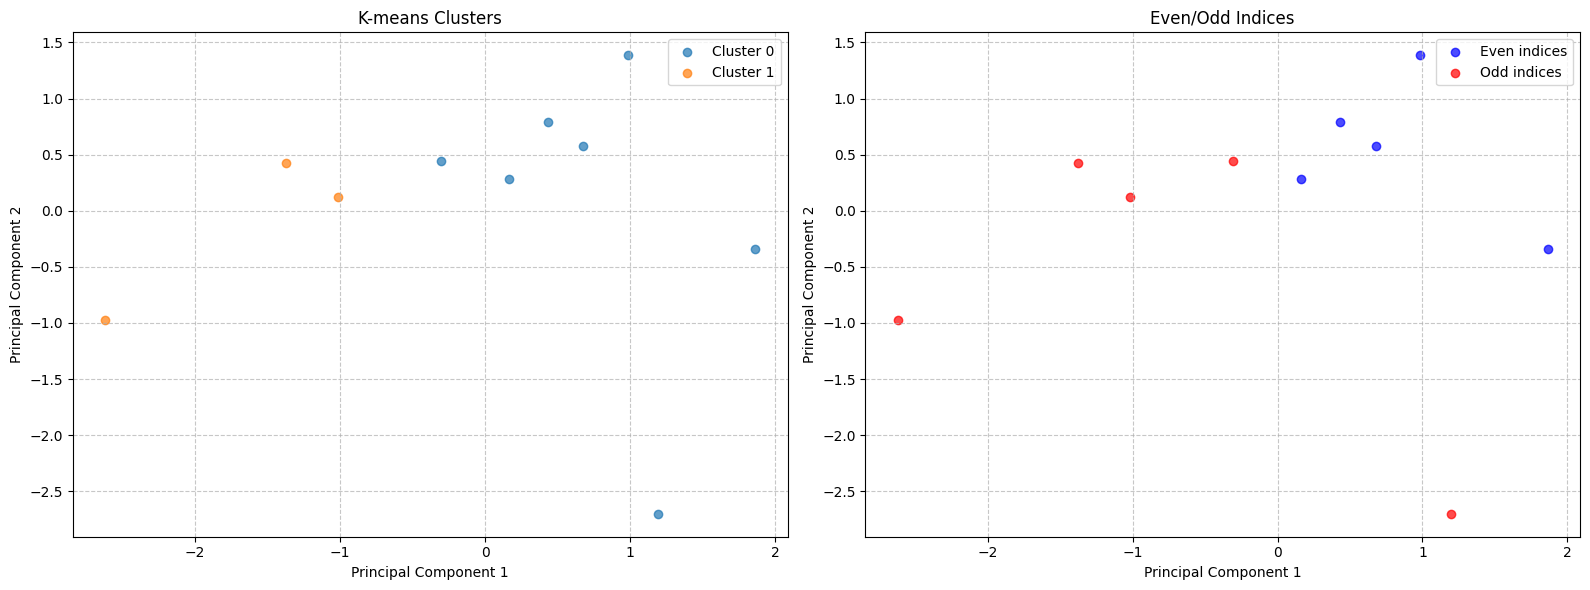

In [8]:
# Apply K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the number of clusters (2 for even/odd indices)
n_clusters = 2

# Initialize and fit K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Evaluate clustering performance
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Compare with expected even/odd grouping
expected_labels = np.arange(len(X_scaled)) % 2
# Handle potential label switching (0->1, 1->0)
accuracy1 = np.mean(cluster_labels == expected_labels)
accuracy2 = np.mean(cluster_labels != expected_labels)
accuracy = max(accuracy1, accuracy2)
print(f"Clustering accuracy compared to even/odd indices: {accuracy:.4f}")

# Visualize the clustering results with PCA data
if X.shape[1] > 2:
    plt.figure(figsize=(12, 10))
    
    # Plot clusters
    for i in range(n_clusters):
        plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], 
                   alpha=0.7, label=f'Cluster {i}')
    
    # Plot cluster centers (transformed to PCA space)
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, marker='X', c='black', label='Centroids')
    
    plt.title('K-means Clustering Results (PCA Projection)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    # Plot comparison between K-means clusters and even/odd indices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # K-means clusters
    for i in range(n_clusters):
        ax1.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], 
                   alpha=0.7, label=f'Cluster {i}')
    ax1.set_title('K-means Clusters')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # Even/odd indices
    even_mask = np.arange(len(X_pca)) % 2 == 0
    odd_mask = ~even_mask
    ax2.scatter(X_pca[even_mask, 0], X_pca[even_mask, 1], alpha=0.7, color='blue', label='Even indices')
    ax2.scatter(X_pca[odd_mask, 0], X_pca[odd_mask, 1], alpha=0.7, color='red', label='Odd indices')
    ax2.set_title('Even/Odd Indices')
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()